# Anomaly Detection in User Activity Logs

### Import necessary libraries

In [2]:
import pandas as pd                                      # for loading and manipulating data
import numpy as np                                      # for numerical operations
import matplotlib.pyplot as plt                        # basic plotting
import seaborn as sns                                 # advanced and pretty plots

### Load the dataset

In [4]:
df = pd.read_csv("user_activity.csv")

### Explore the provided dataset

In [3]:
df.head()

,timestamp,user_id,login_duration_min,data_accessed_MB,files_downloaded,remote_access
0,2025-04-06 04:00:00,user_023,33.417560,229.196409,3,No
1,2025-04-11 23:00:00,user_040,11.951179,221.816183,4,No
2,2025-04-19 07:00:00,user_044,40.490092,178.529723,4,No
3,2025-04-19 09:00:00,user_005,15.915387,227.164901,5,No
4,2025-04-06 00:00:00,user_012,8.761043,175.528028,4,Yes


#### Checking data types and missing values

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   timestamp           505 non-null    object 
 1   user_id             505 non-null    object 
 2   login_duration_min  505 non-null    float64
 3   data_accessed_MB    505 non-null    float64
 4   files_downloaded    505 non-null    int64  
 5   remote_access       505 non-null    object 
dtypes: float64(2), int64(1), object(3)
memory usage: 23.8+ KB


"timestamp" column is object type so it should be converted to datetime for time-based analysis.

In [5]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

Checking if it's applied...

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   timestamp           505 non-null    datetime64[ns]
 1   user_id             505 non-null    object        
 2   login_duration_min  505 non-null    float64       
 3   data_accessed_MB    505 non-null    float64       
 4   files_downloaded    505 non-null    int64         
 5   remote_access       505 non-null    object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 23.8+ KB


In [7]:
df.isnull().sum()

timestamp             0
user_id               0
login_duration_min    0
data_accessed_MB      0
files_downloaded      0
remote_access         0
dtype: int64

Since there are no null values,it confirms that the dataset is completely clean in terms of missing values.

login_duration_min, data_accessed_MB, and files_downloaded are numeric — these will likely be the main features for anomaly detection.

timestamp might also be another.

### Identify normal behavior trends using visualizations.

Here we're trying to figure out what typical user behavior looks like.It's like establishing a “baseline” so we can later spot anything unusual.

We’re not trying to catch anomalies yet, just understanding normal patterns.

Here we are trying to figure out stuff like: How long does a typical user stay logged in?,How much data do they usually access?,How many files do they usually download?

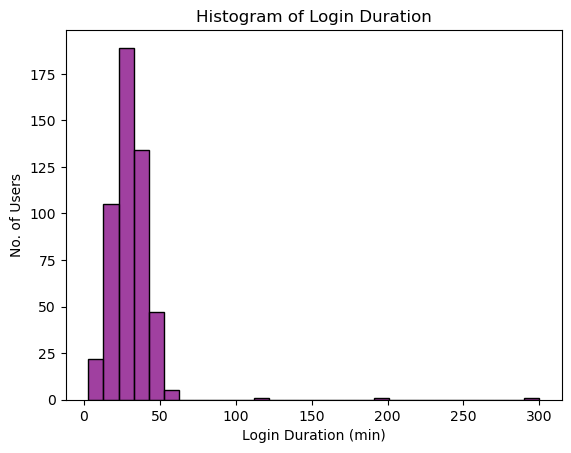

In [8]:
plt.figure()  #It's like opening a fresh canvas before you start plotting.
sns.histplot(df['login_duration_min'],bins=30,color='purple')
plt.title("Histogram of Login Duration")
plt.xlabel("Login Duration (min)")
plt.ylabel("No. of Users")
plt.show()

**'Purpose of bins in the command'** `sns.histplot(df['login_duration_min'],bins=30)`

With `bins=30` and x-axis 0–300, each bin spans 10 units, so the bins are 0–10, 10–20, 20–30, …, up to 290–300.

Range = max - min = 300 - 0 = 300

Bin width = range / number of bins = 300 / 30 = 10

**Normal behaviour:** 20-30 min (approx)

**Potential Outliers:** 120,200,300 mins

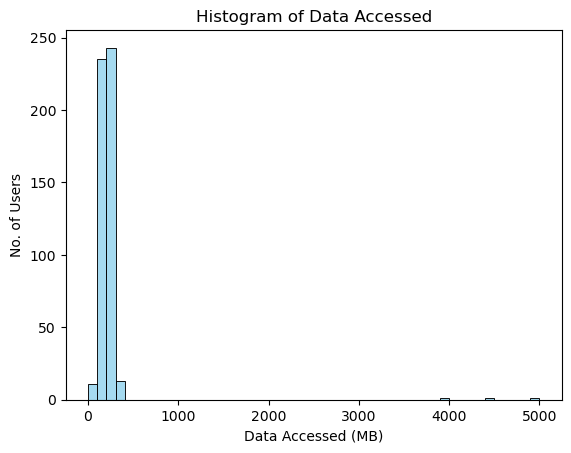

In [9]:
plt.figure()
sns.histplot(df['data_accessed_MB'],bins=50,color='skyblue') #bin width=100 (5000/50)
plt.title("Histogram of Data Accessed")
plt.xlabel("Data Accessed (MB)")
plt.ylabel("No. of Users")
plt.show()

**Normal behaviour:** 100-300 MB (approx)

**Potential Outliers:** 4000,4500,5000 MB

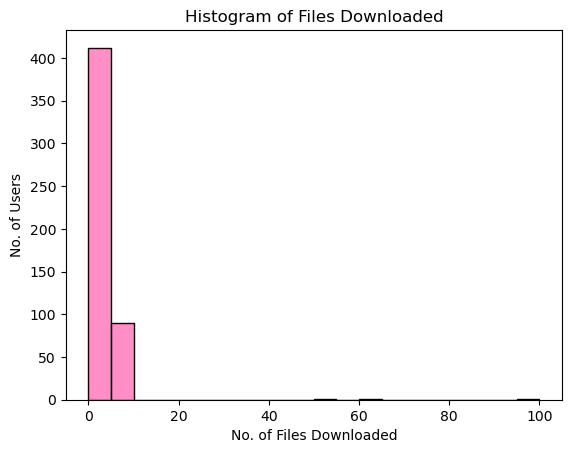

In [10]:
plt.figure()
sns.histplot(df['files_downloaded'],bins=20,color='hotpink')  #bin width=5 (100/20)
plt.title("Histogram of Files Downloaded")
plt.xlabel("No. of Files Downloaded")
plt.ylabel("No. of Users")
plt.show()

**Normal behaviour:** 5 files (approx)

**Potential Outliers:** 55,65,100 files

I just set different colours to each histogram to make it easier to distinguish and it also looks prettier!

For the timestamp column we will look into the hour of the day at which the user loggined in.So we shall first set that as a separate column.

In [11]:
df['hour'] = pd.to_datetime(df['timestamp']).dt.hour
df['hour'] = df['hour'].replace(0, 24) # To plot 24hr makes more sense than to plot hour '0'

In [12]:
df.head()

,timestamp,user_id,login_duration_min,data_accessed_MB,files_downloaded,remote_access,hour
0,2025-04-06 04:00:00,user_023,33.417560,229.196409,3,No,4
1,2025-04-11 23:00:00,user_040,11.951179,221.816183,4,No,23
2,2025-04-19 07:00:00,user_044,40.490092,178.529723,4,No,7
3,2025-04-19 09:00:00,user_005,15.915387,227.164901,5,No,9
4,2025-04-06 00:00:00,user_012,8.761043,175.528028,4,Yes,24


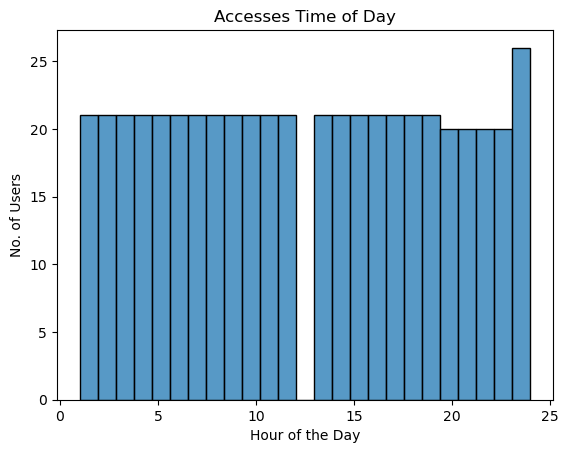

In [13]:
plt.figure()
sns.histplot(df['hour'],bins=25)  #bin width=1 (25/25)
plt.title("Accesses Time of Day")
plt.xlabel("Hour of the Day")
plt.ylabel("No. of Users")
plt.show()

This doesn't seem helpful for our anamoly detection,so let's drop it.

In [14]:
df.head()

,timestamp,user_id,login_duration_min,data_accessed_MB,files_downloaded,remote_access,hour
0,2025-04-06 04:00:00,user_023,33.417560,229.196409,3,No,4
1,2025-04-11 23:00:00,user_040,11.951179,221.816183,4,No,23
2,2025-04-19 07:00:00,user_044,40.490092,178.529723,4,No,7
3,2025-04-19 09:00:00,user_005,15.915387,227.164901,5,No,9
4,2025-04-06 00:00:00,user_012,8.761043,175.528028,4,Yes,24


In [15]:
print(df.columns)

Index(['timestamp', 'user_id', 'login_duration_min', 'data_accessed_MB',
       'files_downloaded', 'remote_access', 'hour'],
      dtype='object')


In [16]:
df.drop(columns='hour', inplace=True)

In [17]:
df.head()

,timestamp,user_id,login_duration_min,data_accessed_MB,files_downloaded,remote_access
0,2025-04-06 04:00:00,user_023,33.417560,229.196409,3,No
1,2025-04-11 23:00:00,user_040,11.951179,221.816183,4,No
2,2025-04-19 07:00:00,user_044,40.490092,178.529723,4,No
3,2025-04-19 09:00:00,user_005,15.915387,227.164901,5,No
4,2025-04-06 00:00:00,user_012,8.761043,175.528028,4,Yes


## Anomaly detection techniques I shall use are:

### 1. Statistical → Interquartile Range (IQR)

Focus on each feature individually: login_duration_min, data_accessed, files_downloaded.

For each feature:

- Compute Q1, Q3, IQR

- Define lower and upper bounds

- Flag values outside bounds as potential anomalies

This gives a feature-wise anomaly view.

I shall now use the `describe()` function to just look at some statistical values of the dataset.

In [18]:
df.describe()

,timestamp,login_duration_min,data_accessed_MB,files_downloaded
count,505,505.000000,505.000000,505.000000
mean,2025-04-11 10:49:54.059406080,30.673913,231.012570,3.384158
min,2025-04-01 00:00:00,3.000000,5.000000,0.000000
25%,2025-04-06 06:00:00,22.742562,172.226144,2.000000
50%,2025-04-11 12:00:00,29.809838,206.278823,3.000000
75%,2025-04-16 16:00:00,36.296288,238.020733,4.000000
max,2025-04-21 19:00:00,300.000000,5000.000000,100.000000
std,NaN,17.802305,335.673082,5.674272


Now applying the IQR code...

**a. For login_duration_min**

In [19]:
Q1 = df.login_duration_min.quantile(0.25)
Q3 = df.login_duration_min.quantile(0.75)
IQR = Q3 - Q1
lower_limit = Q1 - 1.5*IQR
upper_limit = Q3 + 1.5*IQR
df[(df.login_duration_min<lower_limit)|(df.login_duration_min>upper_limit)]

,timestamp,user_id,login_duration_min,data_accessed_MB,files_downloaded,remote_access
79,2025-04-18,user_033,200.000000,5.000000,100,No
83,2025-04-15,user_036,300.000000,5000.000000,50,Yes
251,2025-04-17,user_032,120.000000,4000.000000,60,Yes
303,2025-04-10,user_002,60.788808,120.804859,2,No


**b. For data_accessed_MB**

In [20]:
Q1 = df.data_accessed_MB.quantile(0.25)
Q3 = df.data_accessed_MB.quantile(0.75)
IQR = Q3 - Q1
lower_limit = Q1 - 1.5*IQR
upper_limit = Q3 + 1.5*IQR
df[(df.data_accessed_MB<lower_limit)|(df.data_accessed_MB>upper_limit)]

,timestamp,user_id,login_duration_min,data_accessed_MB,files_downloaded,remote_access
36,2025-04-13 11:00:00,user_008,50.754008,57.572869,7,No
79,2025-04-18 00:00:00,user_033,200.000000,5.000000,100,No
83,2025-04-15 00:00:00,user_036,300.000000,5000.000000,50,Yes
251,2025-04-17 00:00:00,user_032,120.000000,4000.000000,60,Yes
314,2025-04-19 00:00:00,user_045,3.000000,4500.000000,0,Yes
355,2025-04-16 00:00:00,user_025,5.000000,30.000000,0,Yes
406,2025-04-15 03:00:00,user_008,20.778347,55.187231,4,Yes


**Note :** Variable names like Q1, Q3, and IQR can be re-used each time , as python variables exist within the current scope.

When Q1 is calculated for login_duration_min, it’s overwritten when Q1 is again calculated for data_accessed_MB.

Since the calculations are done one column at a time, this overwriting does not cause any issues.

**c. For files_downloaded**

In [21]:
Q1 = df.files_downloaded.quantile(0.25)
Q3 = df.files_downloaded.quantile(0.75)
IQR = Q3 - Q1
lower_limit = Q1 - 1.5*IQR
upper_limit = Q3 + 1.5*IQR
df[(df.files_downloaded<lower_limit)|(df.files_downloaded>upper_limit)]

,timestamp,user_id,login_duration_min,data_accessed_MB,files_downloaded,remote_access
73,2025-04-20 06:00:00,user_026,31.708654,190.735617,8,Yes
79,2025-04-18 00:00:00,user_033,200.000000,5.000000,100,No
83,2025-04-15 00:00:00,user_036,300.000000,5000.000000,50,Yes
191,2025-04-19 21:00:00,user_050,41.033019,262.387104,8,No
196,2025-04-19 01:00:00,user_006,26.904536,222.023737,9,No
246,2025-04-06 06:00:00,user_037,39.504238,229.532742,8,No
251,2025-04-17 00:00:00,user_032,120.000000,4000.000000,60,Yes


### To apply IQR for all 3 columns in single code

In [22]:
# Calculate IQR for each feature
features = ['login_duration_min', 'data_accessed_MB', 'files_downloaded']
df['anomaly_iqr'] = 0  # initialize

for col in features:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5*IQR
    upper_limit = Q3 + 1.5*IQR
    df['anomaly_iqr'] = df['anomaly_iqr'] | ((df[col] < lower_limit) | (df[col] > upper_limit))
    
df['anomaly_iqr'] = df['anomaly_iqr'].astype(int)
df[['user_id', 'anomaly_iqr']].head(10)

,user_id,anomaly_iqr
0,user_023,0
1,user_040,0
2,user_044,0
3,user_005,0
4,user_012,0
5,user_008,0
6,user_028,0
7,user_047,0
8,user_035,0
9,user_037,0


### 2. Unsupervised ML → Isolation Forest

- Works on all three features together.

- Fit the Isolation Forest model and predict anomalies.

- This gives you a multivariate anomaly view, detecting unusual combinations, not just extremes.

### Import Isolation Forest technique from sklearn

In [23]:
from sklearn.ensemble import IsolationForest

We shall now use this technique

In [24]:
# Select required columns
features = ['login_duration_min', 'data_accessed_MB', 'files_downloaded']
X = df[features]

# Initialize the Isolation Forest model
iso = IsolationForest(
    contamination=0.05,   # proportion of expected outliers (can be adjusted)
    random_state=42       # ensures reproducible results
)
# If n_estimators is not mentioned,then by default n_estimators=100

# Fit the model
iso.fit(X)

# Predict anomalies (here -1 = anomaly, 1 = normal)
df['anomaly_if'] = iso.predict(X)


# Display detected anomalies
anomalies = df[df['anomaly_if'] == -1]
print("Detected anomalies:")
print(anomalies)

Detected anomalies:
              timestamp   user_id  login_duration_min  data_accessed_MB  \
35  2025-04-14 09:00:00  user_014           52.706929        303.837399   
36  2025-04-13 11:00:00  user_008           50.754008         57.572869   
48  2025-04-07 00:00:00  user_027           19.323796        132.007193   
57  2025-04-19 13:00:00  user_045           47.547942        166.854954   
79  2025-04-18 00:00:00  user_033          200.000000          5.000000   
83  2025-04-15 00:00:00  user_036          300.000000       5000.000000   
107 2025-04-17 08:00:00  user_042           55.733598        282.100758   
112 2025-04-10 04:00:00  user_037           13.935537        151.651193   
144 2025-04-20 11:00:00  user_001           22.216953        310.526150   
191 2025-04-19 21:00:00  user_050           41.033019        262.387104   
196 2025-04-19 01:00:00  user_006           26.904536        222.023737   
204 2025-04-17 00:00:00  user_024            5.000000        145.186246   
214 2

## Get the *top 5 most suspicious* based on anomaly scores

In [25]:
df['score'] = iso.decision_function(X)  # lower = more anomalous
df_sorted = df.sort_values('score')      # sort ascending
top5 = df_sorted.head(5)                 # top 5 anomalies
print("\nTop 5 most suspicious records:")
print(top5)


Top 5 most suspicious records:
     timestamp   user_id  login_duration_min  data_accessed_MB  \
83  2025-04-15  user_036               300.0            5000.0   
251 2025-04-17  user_032               120.0            4000.0   
79  2025-04-18  user_033               200.0               5.0   
314 2025-04-19  user_045                 3.0            4500.0   
355 2025-04-16  user_025                 5.0              30.0   

     files_downloaded remote_access  anomaly_iqr  anomaly_if     score  
83                 50           Yes            1          -1 -0.345531  
251                60           Yes            1          -1 -0.316379  
79                100            No            1          -1 -0.299917  
314                 0           Yes            1          -1 -0.234745  
355                 0           Yes            1          -1 -0.144315  


Currently, df['anomaly_if'] is -1 for anomaly and 1 for normal. It’s easier to work if we convert it to 0 (normal) / 1 (anomaly) as it is like that in IQR method

In [26]:
df['anomaly_newif'] = df['anomaly_if'].map({1: 0, -1: 1})

**Intersection** (anomaly by both methods)...

In [52]:
df['anomaly_combined_both'] = ((df['anomaly_iqr'] == 1) & (df['anomaly_newif'] == 1)).astype(int)

**Check combined anomalies**...

In [53]:
print("\nIntersection anomalies (both methods):")
print(df[df['anomaly_combined_both'] == 1][['user_id', 'anomaly_iqr', 'anomaly_newif']])


Intersection anomalies (both methods):
      user_id  anomaly_iqr  anomaly_newif
36   user_008            1              1
79   user_033            1              1
83   user_036            1              1
191  user_050            1              1
196  user_006            1              1
246  user_037            1              1
251  user_032            1              1
303  user_002            1              1
314  user_045            1              1
355  user_025            1              1
406  user_008            1              1


Sort by Isolation Forest score to pick top 5

In [29]:
top5_suspects = df[df['anomaly_combined_both'] == 1].sort_values('score').head(5)
print("Top 5 suspects (both methods):")
print(top5_suspects[['user_id', 'login_duration_min', 'data_accessed_MB', 'files_downloaded', 'score']])

Top 5 suspects (both methods):
      user_id  login_duration_min  data_accessed_MB  files_downloaded  \
83   user_036               300.0            5000.0                50   
251  user_032               120.0            4000.0                60   
79   user_033               200.0               5.0               100   
314  user_045                 3.0            4500.0                 0   
355  user_025                 5.0              30.0                 0   

        score  
83  -0.345531  
251 -0.316379  
79  -0.299917  
314 -0.234745  
355 -0.144315  


## Verification using visuals

Now in order to check if remote access was there or not,we set certain colours 

In [42]:
colors = df['remote_access'].map({'Yes': 'green', 'No': 'red'})

Now we compare columns

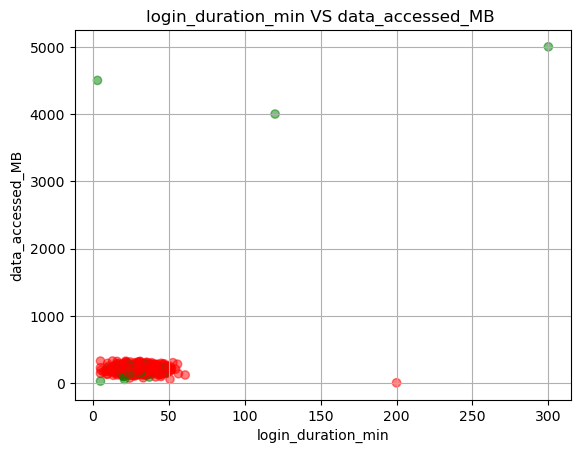

In [51]:
plt.scatter(df['login_duration_min'], df['data_accessed_MB'], c=colors, alpha=0.5)

plt.xlabel('login_duration_min')
plt.ylabel('data_accessed_MB')
plt.title('login_duration_min VS data_accessed_MB ')
plt.grid(True)
plt.show()

the parameter alpha=0.6 controls the transparency (opacity) of the plotted points.Many data points overlap — transparency lets you see density or areas where points stack up.

It can also be plotted using the sns library...

<Axes: xlabel='login_duration_min', ylabel='data_accessed_MB'>

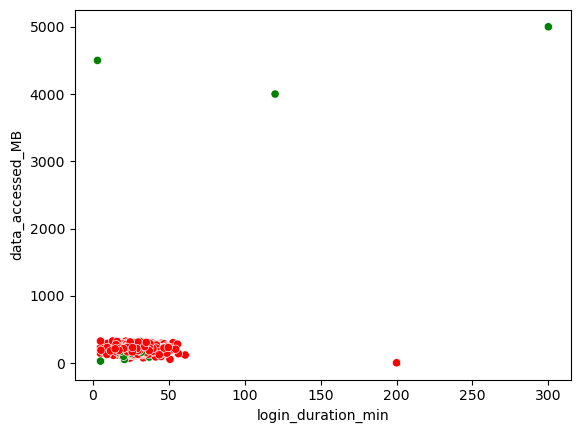

In [49]:
sns.scatterplot(x='login_duration_min', y='data_accessed_MB',c=colors, data=df)

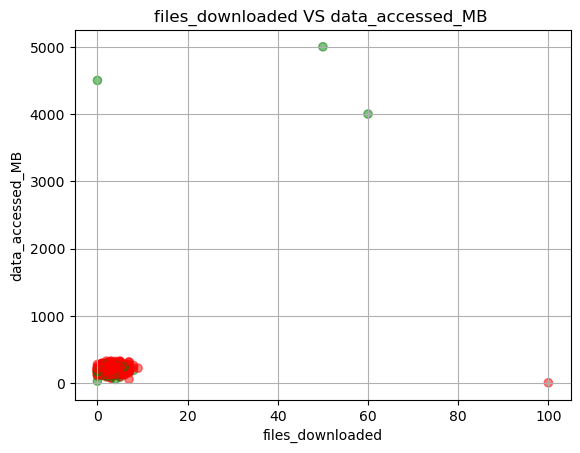

In [50]:
plt.scatter(df['files_downloaded'], df['data_accessed_MB'],c=colors, alpha=0.5)

plt.xlabel('files_downloaded')
plt.ylabel('data_accessed_MB')
plt.title('files_downloaded VS data_accessed_MB ')
plt.grid(True)
plt.show()

From all the above we have figured out the top 5 suspects and it shall be reported with corresponding evidence.

# The Report

**Top 5 Suspects + Evidence**

| user_id      | login_duration_min | data_accessed_MB | files_downloaded | score  | Possible Anomaly Type                                                                     |
| ------------ | ------------------ | ---------------- | ---------------- | ------ | ----------------------------------------------------------------------------------------- |
| **user_036** | 300                | 5000             | 50               | -0.345 | Extremely long login + large data transfer → potential **data exfiltration**              |
| **user_032** | 120                | 4000             | 60               | -0.316 | High file downloads and data accessed → **mass data transfer**                            |
| **user_033** | 200                | 5                | 100              | -0.299 | Many downloads but low data volume → possibly **scripted access** |
| **user_045** | 3                  | 4500             | 0                | -0.234 | Very short login but huge data accessed → **possible automation**    |
| **user_025** | 5                  | 30               | 0                | -0.144 | Very short login, minimal access — could be **false positive** or **failed attempt**      |

- After analyzing user activity logs using both statistical and machine learning approaches, five users consistently stood out as deviating from normal behavior patterns.

- user_036 exhibited an unusually long session (300 minutes) with large data transfers, suggesting possible data exfiltration.

- user_045 accessed significant data within just 3 minutes — an abnormal pattern that hints at automated access.

- Others, such as user_033, showed suspiciously high download counts with minimal data.